# Self-Supervised Learning with DINO on CIFAR-10

Goal: Learn meaningful image representations without using labels during training,
and evaluate their quality using visualization and clustering.


## Imports and Setup


In [63]:
!pip install pytorch_lightning


In [64]:
!pip -q install umap-learn


In [65]:
# =========================
# 0. Imports & Setup
# =========================

# stdlib
import os
from pathlib import Path
from glob import glob
from collections import defaultdict

# data & viz
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.utils import make_grid
from torch.nn.init import trunc_normal_

# pytorch-lightning
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision.models import resnet18

# evaluation / embedding
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics.pairwise import cosine_similarity
import umap

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


device: cuda


##  Dataset and Augmentations



In [46]:
root_dir = Path("/content/DINO_DATA/cifar10")
train_dir = root_dir / "train"
train_dir.mkdir(parents=True, exist_ok=True)

# Download CIFAR-10 (only once)
CIFAR10(root=str(root_dir), download=True)

# Save images directly into numeric-label folders (0..9)
dataset = CIFAR10(root=str(root_dir), download=False)
for idx, (img, label) in enumerate(tqdm(dataset, desc="Saving CIFAR images")):
    class_folder = train_dir / str(label)  # numeric folder
    class_folder.mkdir(parents=True, exist_ok=True)
    img.save(class_folder / f"{idx:05d}.png")

print("✅ Images saved into numeric class folders under:", train_dir)


Saving CIFAR images: 100%|██████████| 50000/50000 [00:26<00:00, 1856.16it/s]

✅ Images saved into numeric class folders under: /content/DINO_DATA/cifar10/train


In [47]:
class ImageDataset(Dataset):
    def __init__(self, root, split='train'):
        self.split = split
        self.image_paths = []
        # TODO: save image paths to file to avoid reading overhead
        stamp_idxs = sorted(os.listdir(root))
        for stamp_idx in stamp_idxs:
            image_paths = glob.glob(os.path.join(root, f'{stamp_idx}/[0-9]*.png'))
            image_paths = sorted(filter(lambda x: 'key' not in x, image_paths))
            self.image_paths += image_paths

    def __len__(self):
        if self.split == 'train':
            return len(self.image_paths)
        return 1

    def __getitem__(self, idx):
        if self.split != 'train':  # randomly choose an image for validation
            idx = np.random.choice(len(self.image_paths), 1)[0]
        image = imageio.imread(self.image_paths[idx])
        if image.shape[-1] == 4:  # if there is alpha channel
            image[image[..., -1] == 0, :3] = 255  # a=0 to white
            image = image[..., :3]
        return self.transform(image)


class ValTransform:
    def __init__(self):
        self.norm = A.Compose([
            A.Resize(224, 224, interpolation=cv2.INTER_AREA),
            A.Normalize(),
            ToTensorV2()
        ])

        self.orig = A.Compose([
            A.Resize(224, 224, interpolation=cv2.INTER_AREA),
            ToTensorV2()
        ])

    def __call__(self, image):
        return [self.orig(image=image)['image'], self.norm(image=image)['image']]


class TrainTransform:
    def __init__(self, global_crops_scale, local_crops_scale, local_crops_number):
        flip_and_color_jitter = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1, p=0.8),
            A.ToGray(p=0.2)
        ])
        normalize = A.Compose([
            A.Normalize(),
            ToTensorV2()
        ])

        # area interpolation should be better for small images
        # first global crop
        self.global_crop1 = A.Compose([
            A.RandomResizedCrop((224, 224), scale=global_crops_scale, interpolation=cv2.INTER_AREA),
            flip_and_color_jitter,
            A.GaussianBlur(p=1.0),
            normalize,
        ])
        # second global crop
        self.global_crop2 = A.Compose([
            A.RandomResizedCrop((224, 224), scale=global_crops_scale, interpolation=cv2.INTER_AREA),
            flip_and_color_jitter,
            A.GaussianBlur(p=0.1),
            A.Solarize(p=0.2),
            normalize,
        ])
        # transformation for the local small crops
        self.local_crops_number = local_crops_number
        self.local_crop = A.Compose([
            A.RandomResizedCrop((96, 96), scale=local_crops_scale, interpolation=cv2.INTER_AREA),
            flip_and_color_jitter,
            A.GaussianBlur(p=0.5),
            normalize,
        ])

    def __call__(self, image):
        crops = [self.global_crop1(image=image)['image'], self.global_crop2(image=image)['image']]
        for _ in range(self.local_crops_number):
            crops += [self.local_crop(image=image)['image']]
        return crops


## DINO Model


### DINO Loss


In [66]:
from einops import reduce

class DINOLoss(nn.Module):
    def __init__(self, out_dim, ncrops, warmup_teacher_temp, final_teacher_temp,
                 warmup_teacher_temp_epochs, nepochs,
                 student_temp=0.1, center_momentum=0.9):
        super().__init__()
        self.student_temp = student_temp
        self.center_momentum = center_momentum
        self.ncrops = ncrops
        self.register_buffer("center", torch.zeros(1, out_dim))
        self.teacher_temp_schedule = np.concatenate((
            np.linspace(warmup_teacher_temp, final_teacher_temp, warmup_teacher_temp_epochs),
            np.ones(nepochs - warmup_teacher_temp_epochs) * final_teacher_temp
        ))

    def forward(self, student_output, teacher_output, epoch):
        """
        Cross-entropy between softmax outputs of the teacher and student networks.
        student_output: (B*ncrops, out_dim)
        teacher_output: (B*2, out_dim)
        """
        student_out = student_output/self.student_temp
        student_out = student_out.chunk(self.ncrops) # global views + local views

        # teacher centering and sharpening
        temp = self.teacher_temp_schedule[epoch]
        teacher_out = F.softmax((teacher_output-self.center)/temp, dim=-1)
        teacher_out = teacher_out.chunk(2) # global views

        total_loss = n_loss_terms = 0
        for iq, q in enumerate(teacher_out):
            for v in range(len(student_out)):
                if v == iq: # skip cases where student and teacher operate on the same view
                    continue
                loss = reduce(-q*F.log_softmax(student_out[v], dim=-1), 'b o -> b', 'sum')
                total_loss += loss.mean()
                n_loss_terms += 1
        total_loss /= n_loss_terms
        self.update_center(teacher_output)
        return total_loss

    def update_center(self, teacher_output):
        """
        Update center used for teacher output.
        """
        batch_center = reduce(teacher_output, 'b o -> 1 o', 'mean')

        self.center = self.center * self.center_momentum + \
                      batch_center * (1 - self.center_momentum)

## Training Utilities


In [67]:
def extract_model_state_dict(ckpt_path, model_name='model', prefixes_to_ignore=[]):
    checkpoint = torch.load(ckpt_path, map_location='cpu')
    checkpoint_ = {}
    if 'state_dict' in checkpoint: # if it's a pytorch-lightning checkpoint
        checkpoint = checkpoint['state_dict']
    for k, v in checkpoint.items():
        if not k.startswith(model_name):
            continue
        k = k[len(model_name)+1:]
        for prefix in prefixes_to_ignore:
            if k.startswith(prefix):
                print('ignore', k)
                break
        else:
            checkpoint_[k] = v
    return checkpoint_


def load_ckpt(model, ckpt_path, model_name='model', prefixes_to_ignore=[]):
    model_dict = model.state_dict()
    checkpoint_ = extract_model_state_dict(ckpt_path, model_name, prefixes_to_ignore)
    model_dict.update(checkpoint_)
    model.load_state_dict(model_dict)

### Projection Head and Multi-Crop Wrapper


In [68]:
class DINOHead(nn.Module):
    def __init__(self, in_dim, out_dim, norm_last_layer=True,
                 nlayers=3, hidden_dim=2048, bottleneck_dim=256):
        super().__init__()
        nlayers = max(nlayers, 1)
        if nlayers == 1:
            self.mlp = nn.Linear(in_dim, bottleneck_dim)
        else:
            layers = [nn.Linear(in_dim, hidden_dim), nn.GELU()]
            for _ in range(nlayers - 2):
                layers += [nn.Linear(hidden_dim, hidden_dim), nn.GELU()]
            layers += [nn.Linear(hidden_dim, bottleneck_dim)]
            self.mlp = nn.Sequential(*layers)
        self.apply(self._init_weights)
        self.last_layer = nn.utils.weight_norm(nn.Linear(bottleneck_dim, out_dim, bias=False))
        self.last_layer.weight_g.data.fill_(1)
        if norm_last_layer:
            self.last_layer.weight_g.requires_grad = False

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.mlp(x)
        x = nn.functional.normalize(x, dim=-1, p=2)
        x = self.last_layer(x)
        return x

In [69]:
class MultiCropWrapper(nn.Module):
    """
    Perform forward pass separately on each resolution input.
    The inputs corresponding to a single resolution are clubbed and single
    forward is run on the same resolution inputs. Hence we do several
    forward passes = number of different resolutions used. We then
    concatenate all the output features and run the head forward on these
    concatenated features.
    """
    def __init__(self, backbone, head):
        super().__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        """
        x: list of input image tensors
        """
        idx_crops = torch.cumsum(torch.unique_consecutive(
            torch.tensor([inp.shape[-1] for inp in x]),
            return_counts=True,
        )[1], 0) # [2, 10] for student, [2] for teacher
        start_idx = 0
        out = []
        for end_idx in idx_crops:
            out += [self.backbone(torch.cat(x[start_idx:end_idx]))]
            start_idx = end_idx
        return self.head(torch.cat(out))

In [70]:
# from argparse import Namespace

# hparams = Namespace(
#     root_dir='/content/DINO_DATA/cifar10/train',
#     exp_name='dino_colab_safe',
#     arch='tiny',                    # use tiny model
#     patch_size=4,                   # smaller patch size
#     out_dim=65536,
#     drop_path_rate=0.1,
#     norm_last_layer=True,
#     momentum_teacher=0.996,
#     global_crops_scale=(0.5, 1.0),
#     local_crops_number=2,          # significantly reduced
#     local_crops_scale=(0.1, 0.5),
#     warmup_teacher_temp=0.04,
#     final_teacher_temp=0.04,
#     warmup_teacher_temp_epochs=0,
#     batch_size=4,                  # low batch size
#     num_workers=2,
#     num_epochs=50,
#     num_gpus=1,
#     weight_decay_init=0.04,
#     weight_decay_end=0.4,
#     clip_grad=3.0,
#     pretrained_path='',
#     ckpt_path='',
#     fp16=False,                     # enable mixed precision
#     warmup_epochs=10,
#     lr=5e-4,
#     ep_freeze_last_layer=1,
# )


## Training

In [71]:
import matplotlib.cm as cm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def att2img(att, cmap=cm.get_cmap('plasma')):
    x = att.cpu().numpy()
    mi, ma = np.min(x), np.max(x)
    x = (x - mi) / (ma - mi + 1e-8)
    x_ = cmap(x)[..., :3]
    x_ = torch.from_numpy(x_).permute(2, 0, 1)
    return x_

def cosine_scheduler(base_value, final_value, epochs, niter_per_ep,
                     warmup_epochs=0, start_warmup_value=1e-6):
    warmup_schedule = np.array([])
    warmup_iters = warmup_epochs * niter_per_ep
    if warmup_epochs > 0:
        warmup_schedule = np.linspace(start_warmup_value, base_value, warmup_iters)
    iters = np.arange(epochs * niter_per_ep - warmup_iters)
    schedule = final_value + 0.5 * (base_value - final_value) * \
               (1 + np.cos(np.pi * iters / len(iters)))
    schedule = np.concatenate((warmup_schedule, schedule))
    assert len(schedule) == epochs * niter_per_ep
    return schedule

class DINOSystem(LightningModule):
    def __init__(self, hparams):
        super().__init__()
        for k, v in vars(hparams).items():
            setattr(self, k, v)
        self.automatic_optimization = False

        # 🧠 Replace ViT with ResNet-18
        student_backbone = models.resnet18(pretrained=False)
        student_backbone.fc = torch.nn.Identity()

        teacher_backbone = models.resnet18(pretrained=False)
        teacher_backbone.fc = torch.nn.Identity()

        self.student = MultiCropWrapper(student_backbone, DINOHead(512, self.out_dim, self.norm_last_layer))
        self.teacher = MultiCropWrapper(teacher_backbone, DINOHead(512, self.out_dim))

        if self.pretrained_path:
            print(f'loading pretrained model from {self.pretrained_path} ...')
            ckpt = torch.load(self.pretrained_path, map_location=device)
            self.student.load_state_dict(ckpt['teacher'])
        self.teacher.load_state_dict(self.student.state_dict())
        for p in self.teacher.parameters():
            p.requires_grad = False

        self.loss = DINOLoss(self.out_dim,
                             self.local_crops_number + 2,
                             self.warmup_teacher_temp,
                             self.final_teacher_temp,
                             self.warmup_teacher_temp_epochs,
                             self.num_epochs)

    def setup(self, stage=None):
        print('loading image paths ...')
        self.train_dataset = ImageDataset(self.root_dir, 'train')
        print(f'{len(self.train_dataset.image_paths)} image paths loaded!')

        self.val_dataset = copy.deepcopy(self.train_dataset)
        self.val_dataset.split = 'val'

        self.train_dataset.transform = TrainTransform(
            self.global_crops_scale,
            self.local_crops_scale,
            self.local_crops_number
        )
        self.val_dataset.transform = ValTransform()

    def configure_optimizers(self):
        regularized, not_regularized = [], []
        for n, p in self.student.named_parameters():
            if not p.requires_grad:
                continue
            if n.endswith(".bias") or len(p.shape) == 1:
                not_regularized.append(p)
            else:
                regularized.append(p)
        param_groups = [{'params': regularized},
                        {'params': not_regularized, 'weight_decay': 0.}]
        self.lr = self.lr * (self.batch_size * max(1, self.num_gpus) / 256)
        opt = torch.optim.AdamW(param_groups, self.lr)
        return opt

    def train_dataloader(self):
        self.loader = DataLoader(self.train_dataset,
                                 shuffle=True,
                                 num_workers=self.num_workers,
                                 batch_size=self.batch_size,
                                 pin_memory=True,
                                 drop_last=True)
        niter = len(self.loader)
        self.lr_sch = cosine_scheduler(self.lr, 1e-6, self.num_epochs, niter)
        self.wd_sch = cosine_scheduler(self.weight_decay_init, self.weight_decay_end,
                                       self.num_epochs, niter)
        self.mm_sch = cosine_scheduler(self.momentum_teacher, 1.0,
                                       self.num_epochs, niter)
        return self.loader

    def val_dataloader(self):
        return DataLoader(self.val_dataset,
                          shuffle=False,
                          num_workers=self.num_workers,
                          batch_size=1,
                          pin_memory=True)

    def training_step(self, batch, batch_idx):
        opt = self.optimizers()
        step = min(self.global_step, len(self.lr_sch) - 1)
        m = self.mm_sch[step]

        for i, param_group in enumerate(opt.param_groups):
            param_group['lr'] = self.lr_sch[step]
            if i == 0:
                param_group['weight_decay'] = self.wd_sch[step]


        teacher_output = self.teacher([x.to(device) for x in batch[:2]])
        student_output = self.student([x.to(device) for x in batch])
        loss = self.loss(student_output, teacher_output, self.current_epoch)

        opt.zero_grad()
        self.manual_backward(loss)
        if self.clip_grad > 0:
            torch.nn.utils.clip_grad_norm_(self.student.parameters(), self.clip_grad)
        if self.current_epoch < self.ep_freeze_last_layer:
            for n, p in self.student.named_parameters():
                if "last_layer" in n:
                    p.grad = None
        opt.step()

        m = self.mm_sch[min(self.global_step, len(self.mm_sch) - 1)]
        for ps, pt in zip(self.student.parameters(), self.teacher.parameters()):
            pt.data.mul_(m).add_((1 - m) * ps.data)

        self.log('rates/lr', opt.param_groups[0]['lr'])
        self.log('rates/weight_decay', opt.param_groups[0]['weight_decay'])
        self.log('rates/momentum', m)
        self.log('train/loss', loss, True)

    def on_validation_start(self):
        self.val_outputs = []

    def validation_step(self, batch, batch_idx):
        img_orig, img_norm = batch
        img_norm = img_norm.to(device)
        self.val_outputs.append({'attentions': torch.zeros((6, img_norm.shape[2], img_norm.shape[3])), 'img': img_orig})

    def on_validation_epoch_end(self):
        if not self.val_outputs:
            return
        atts = self.val_outputs[0]['attentions']
        tb = self.logger.experiment
        tb.add_image('image', self.val_outputs[0]['img'][0], self.global_step)
        atts_vis = [att2img(att) for att in atts]
        tb.add_image('attentions', make_grid(atts_vis, nrow=3), self.global_step)
        self.val_outputs.clear()

/tmp/ipython-input-3115288566.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  def att2img(att, cmap=cm.get_cmap('plasma')):


In [ ]:
#training

if __name__ == '__main__':

    hparams = Namespace(
      root_dir='/content/DINO_DATA/cifar10/train',
      exp_name='dino_resnet_min',
      arch='resnet18',
      patch_size=4,
      out_dim=512,
      drop_path_rate=0.0,
      norm_last_layer=True,
      momentum_teacher=0.996,
      global_crops_scale=(0.5, 1.0),
      local_crops_number=0,
      local_crops_scale=(0.1, 0.5),
      warmup_teacher_temp=0.04,
      final_teacher_temp=0.04,
      warmup_teacher_temp_epochs=0,
      batch_size=1,
      num_workers=0,
      num_epochs=3,
      num_gpus=1,
      weight_decay_init=0.04,
      weight_decay_end=0.4,
      clip_grad=3.0,
      pretrained_path='',
      ckpt_path='',
      fp16=False,
      warmup_epochs=1,
      lr=1e-4,
      ep_freeze_last_layer=1,
)


    system = DINOSystem(hparams)

    ckpt_cb = ModelCheckpoint(dirpath=f'ckpts/{hparams.exp_name}',
                              filename='{epoch:d}',
                              save_top_k=-1)
    pbar = TQDMProgressBar(refresh_rate=1)
    callbacks = [ckpt_cb, pbar]

    logger = TensorBoardLogger(save_dir="logs",
                               name=hparams.exp_name,
                               default_hp_metric=False)

    trainer = Trainer(
        max_epochs=hparams.num_epochs,
        callbacks=callbacks,
        logger=logger,
        enable_model_summary=False,
        precision=16 if hparams.fp16 else 32,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        num_sanity_val_steps=1
    )

    # Auto-resume logic
    ckpt_dir = f'ckpts/{hparams.exp_name}'
    last_ckpt = None
    if os.path.exists(ckpt_dir):
        ckpts = sorted(glob(f'{ckpt_dir}/*.ckpt'))
        if ckpts:
            last_ckpt = ckpts[-1]
            print(f"🔁 Resuming from checkpoint: {last_ckpt}")
        else:
            print("🚀 No checkpoints found, starting fresh.")
    else:
        print("🚀 Checkpoint directory does not exist, starting fresh.")

    # Start or resume training
    trainer.fit(system, ckpt_path=last_ckpt if last_ckpt else None)


/tmp/ipython-input-809314136.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  def att2img(att, cmap=cm.get_cmap('plasma')):
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_

🚀 Checkpoint directory does not exist, starting fresh.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


loading image paths ...
50000 image paths loaded!


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/tmp/ipython-input-2202659294.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(self.image_paths[idx])


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


### Dowloading checkpoints

In [ ]:
!zip -r dino_ckpts.zip ckpts/
from google.colab import files
files.download('dino_ckpts.zip')


  adding: ckpts/ (stored 0%)
  adding: ckpts/dino_resnet_min/ (stored 0%)
  adding: ckpts/dino_resnet_min/epoch=0.ckpt (deflated 8%)
  adding: ckpts/dino_resnet_min/epoch=2.ckpt (deflated 8%)
  adding: ckpts/dino_resnet_min/epoch=1.ckpt (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
torch.serialization.add_safe_globals({
    np.core.multiarray.scalar: np.core.multiarray.scalar,
    np.dtype: np.dtype,
    np.dtypes.Float64DType: np.dtypes.Float64DType
})


## Evaluation and Inference

### Evaluation

In [72]:
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)


In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
torch.serialization.add_safe_globals({
    np.core.multiarray.scalar: np.core.multiarray.scalar,
    np.dtype: np.dtype,
})

# sometimes needed depending on numpy/torch versions
if hasattr(np, "dtypes") and hasattr(np.dtypes, "Float64DType"):
    torch.serialization.add_safe_globals({np.dtypes.Float64DType: np.dtypes.Float64DType})


In [74]:
ckpt_path = "/content/drive/MyDrive/ckpts/dino_resnet_min/epoch=2.ckpt"
hparams.out_dim = 512
system = DINOSystem.load_from_checkpoint(ckpt_path, hparams=hparams)
backbone = system.student.backbone.eval().to(device)

In [75]:
eval_transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [76]:
# Collect eval image paths + labels (one place only) ---
data_root = "/content/DINO_DATA/cifar10/train"
per_class = 200

image_paths, labels = [], []
for cls in sorted(os.listdir(data_root)):
    paths = sorted(glob(os.path.join(data_root, cls, "*.png")))[:per_class]
    image_paths.extend(paths)
    labels.extend([int(cls)] * len(paths))

labels = np.array(labels)
print("eval images:", len(image_paths))


eval images: 2000


In [77]:
#  Feature extraction (one function only) ---
def extract_features(backbone, image_paths, transform, batch_size=64):
    backbone.eval()
    feats = []
    with torch.no_grad():
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i + batch_size]
            x = torch.stack([transform(Image.open(p).convert("RGB")) for p in batch_paths]).to(device)
            f = backbone(x).cpu().numpy()
            feats.append(f)
    return np.concatenate(feats, axis=0)

# DINO backbone features
dino_feats = extract_features(backbone, image_paths, eval_transform, batch_size=64)
print("dino feats:", dino_feats.shape)


dino feats: (2000, 512)


In [93]:
# 2D projection for visualization
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
dino_2d = reducer.fit_transform(dino_feats)

print("dino_2d shape:", dino_2d.shape)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


dino_2d shape: (2000, 2)


In [78]:
#  Baseline (random ResNet-18) features ---
random_backbone = resnet18(weights=None)
random_backbone.fc = nn.Identity()
random_backbone = random_backbone.eval().to(device)

rand_feats = extract_features(random_backbone, image_paths, eval_transform, batch_size=64)
print("rand feats:", rand_feats.shape)


rand feats: (2000, 512)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


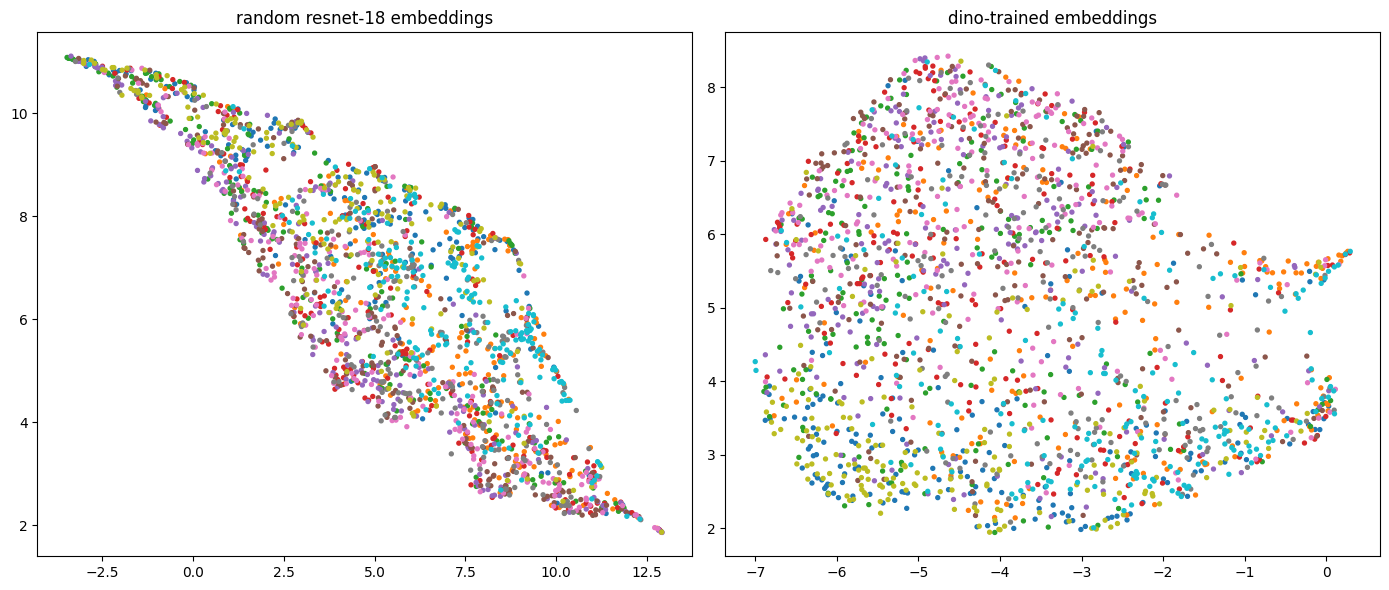

In [80]:
#  UMAP visualization (side-by-side) ---
def umap_2d(feats):
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
    return reducer.fit_transform(feats)

rand_2d = umap_2d(rand_feats)
dino_2d = umap_2d(dino_feats)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].scatter(rand_2d[:, 0], rand_2d[:, 1], c=labels, cmap="tab10", s=8)
axes[0].set_title("random resnet-18 embeddings")
axes[1].scatter(dino_2d[:, 0], dino_2d[:, 1], c=labels, cmap="tab10", s=8)
axes[1].set_title("dino-trained embeddings")
plt.tight_layout()
plt.show()


### Kmeans Evaluation

In [81]:
# KMeans + NMI (quantitative) ---
def kmeans_nmi(feats, labels, k=10):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = km.fit_predict(feats)
    return normalized_mutual_info_score(labels, clusters)

print("nmi (random):", kmeans_nmi(rand_feats, labels))
print("nmi (dino):  ", kmeans_nmi(dino_feats, labels))


nmi (random): 0.06135336136333291
nmi (dino):   0.08378183788041639


In [82]:
nmi_rand = kmeans_nmi(rand_feats, labels)
nmi_dino = kmeans_nmi(dino_feats, labels)

print(f"nmi random: {nmi_rand:.4f}")
print(f"nmi dino:   {nmi_dino:.4f}")
print("improvement:", round(nmi_dino - nmi_rand, 4))


nmi random: 0.0614
nmi dino:   0.0838
improvement: 0.0224


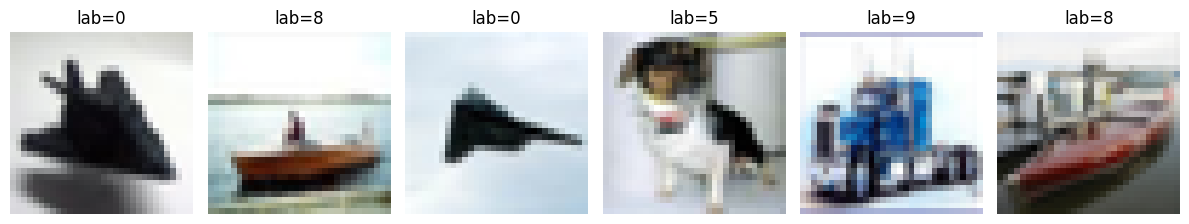

In [83]:
#  Nearest neighbors (one clear demo) ---
def show_neighbors(query_idx, feats, image_paths, labels, topk=6):
    sims = cosine_similarity(feats[query_idx:query_idx+1], feats)[0]
    idxs = sims.argsort()[-topk:][::-1]

    plt.figure(figsize=(12, 3))
    for j, k in enumerate(idxs):
        img = Image.open(image_paths[k]).convert("RGB")
        plt.subplot(1, topk, j + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"lab={labels[k]}")
    plt.tight_layout()
    plt.show()

show_neighbors(query_idx=0, feats=dino_feats, image_paths=image_paths, labels=labels, topk=6)


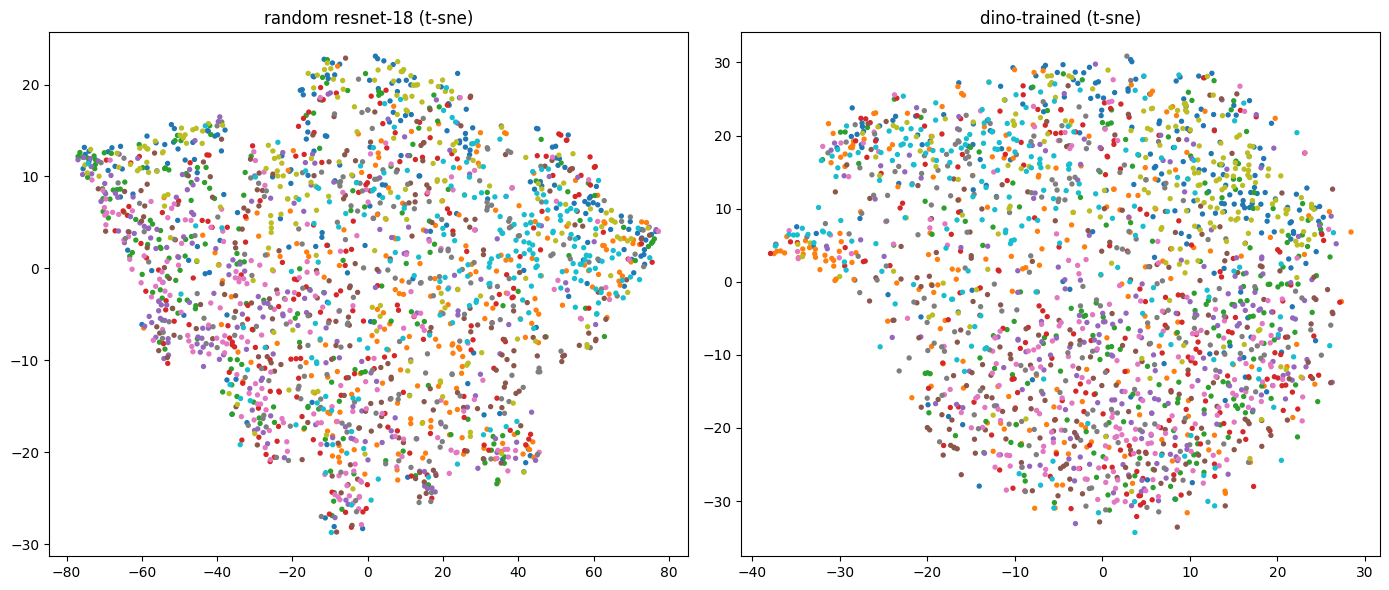

In [66]:
# t-SNE visualization (reuse extracted features) ---
from sklearn.manifold import TSNE

def tsne_2d(feats):
    return TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=42).fit_transform(feats)

rand_tsne = tsne_2d(rand_feats)
dino_tsne = tsne_2d(dino_feats)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].scatter(rand_tsne[:, 0], rand_tsne[:, 1], c=labels, cmap="tab10", s=8)
axes[0].set_title("random resnet-18 (t-sne)")
axes[1].scatter(dino_tsne[:, 0], dino_tsne[:, 1], c=labels, cmap="tab10", s=8)
axes[1].set_title("dino-trained (t-sne)")
plt.tight_layout()
plt.show()


### Kmeans fitting

In [94]:
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
cluster_ids = kmeans.fit_predict(dino_feats)


In [95]:
from collections import Counter

cluster_to_label = {}

for c in range(10):
    cluster_labels = labels[cluster_ids == c]
    most_common = Counter(cluster_labels).most_common(1)[0][0]
    cluster_to_label[c] = most_common

print(cluster_to_label)


{0: np.int64(1), 1: np.int64(6), 2: np.int64(6), 3: np.int64(3), 4: np.int64(9), 5: np.int64(1), 6: np.int64(1), 7: np.int64(1), 8: np.int64(8), 9: np.int64(9)}


In [96]:
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
clusters = kmeans.fit_predict(dino_feats)
print("clusters shape:", clusters.shape)


clusters shape: (2000,)


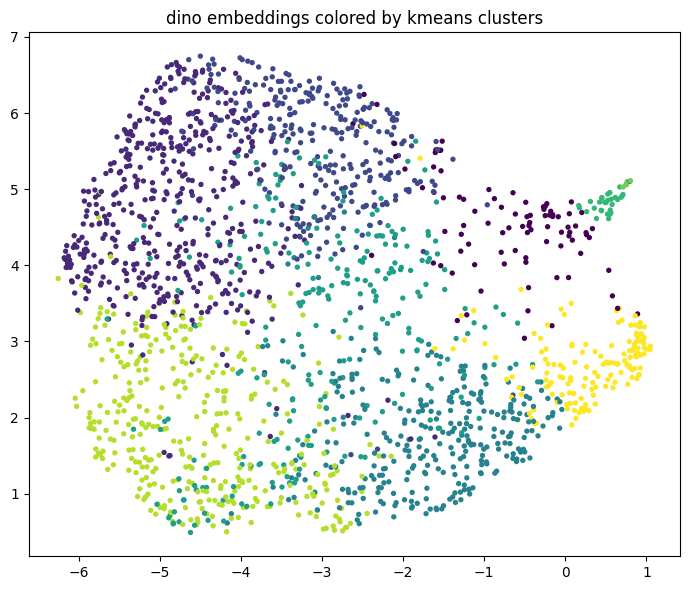

In [97]:
plt.figure(figsize=(7, 6))
plt.scatter(dino_2d[:, 0], dino_2d[:, 1], c=clusters, s=8)
plt.title("dino embeddings colored by kmeans clusters")
plt.tight_layout()
plt.show()


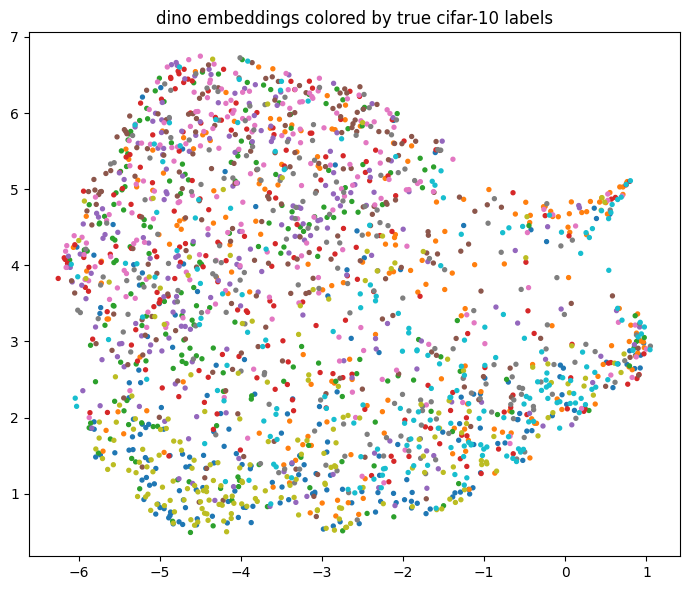

In [98]:
plt.figure(figsize=(7, 6))
plt.scatter(dino_2d[:, 0], dino_2d[:, 1], c=labels, cmap="tab10", s=8)
plt.title("dino embeddings colored by true cifar-10 labels")
plt.tight_layout()
plt.show()


### Inference

In [86]:
path = '/content/DINO_DATA/cifar10/train/0/00029.png'

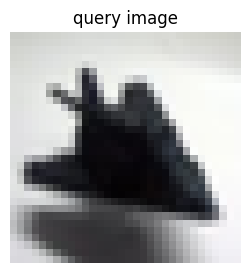

embedding shape: (1, 512)


In [87]:
backbone.eval()
img = Image.open(path).convert("RGB")
x = eval_transform(img).unsqueeze(0).to(device)

with torch.no_grad():
    q_feat = backbone(x).cpu().numpy()  # shape (1, D)

plt.figure(figsize=(3,3))
plt.imshow(img)
plt.axis("off")
plt.title("query image")
plt.show()

print("embedding shape:", q_feat.shape)


In [88]:
# q_feat is (1, 512)
cluster = kmeans.predict(q_feat)[0]
pred_label = cluster_to_label[cluster]

print("predicted class (kmeans-based):", pred_label)

predicted class (kmeans-based): 9
